In [1]:
%pylab qt
%matplotlib inline

import datetime
import astropy.constants as const
import sympy as sympy
import warnings
import pandas
from orbital_parameters import *

def epoch_to_julian(date):
    """converts epoch to julian day"""
    J2000 = 2451545.
    delta = (date - datetime.datetime(2000, 1, 1, 12))
    j     = delta.days + delta.seconds/24/3600
    return J2000 + j

def mysavefig(name):
    plt.tight_layout()
    plt.savefig(name, dpi=200)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# calculate heliocentric ecliptic coordinates in au
def heliocentric_ecliptic_coordinates(datetime, a, e, Omega, omega, i, M0, t0):
    """
    PARAMETERS
        datetime: date at which we want to know the position of the comet
        a       : semimajor axis of the ellipse in astronomical units
        e       : eccentricity
        Omega   : longitude of ascending mode in degree
        omega   : argument of periapsis in degree
        i       : inclinaison in degree
        M0      : mean anomaly in degree at epoch
        t0      : reference epoch
    RETURNS
        X,Y and Z heliocentric ecliptic coordinates in au
    """
    
    # Convert values in rad, au and julian days
    Omega *= np.pi/180
    omega *= np.pi/180
    i     *= np.pi/180
    M0    *= np.pi/180
    t0     = epoch_to_julian(t0)
    
    # other relevant quantities
    P = (2*np.pi*np.sqrt((a*const.au)**3/const.G/const.M_sun)).value / 24/3600 # orbital period in days
    n = 2*np.pi/P # average motion (average orbital angular speed) in rad per day

    # compute mean anomaly in rad at a given date
    t = epoch_to_julian(datetime)
    M = M0 + n*(t-t0)

    # compute excentric anomaly in rad at a given date
    x = sympy.Symbol("x")
    E = sympy.solvers.nsolve(x - e*sympy.sin(x) - M, x, 1)
    E = float(E)

    # compute true anomaly in rad at a given date
    cos_nu = (np.cos(E) - e) / (1 - e*np.cos(E))
    sin_nu = (np.sqrt(1-e**2)*np.sin(E)) / (1 - e*np.cos(E))
    tan_nu = (np.sqrt(1-e**2)*np.sin(E)) / (np.cos(E)-e)
    tan_demi_nu = np.sqrt((1+e)/(1-e))*np.tan(E/2)
    nu = 2*np.arctan(tan_demi_nu)
    # checking
    ref_str = "%10.3f %10.3f %10.3f %10.3f"%(cos_nu, sin_nu, tan_nu, tan_demi_nu)
    num_str = "%10.3f %10.3f %10.3f %10.3f"%(np.cos(nu), np.sin(nu), np.tan(nu), np.tan(nu/2))
    if not (ref_str==num_str):
        warnings.warn("true_anomaly value not reliable")

    # compute heliocentric distance in au
    r = a*(1-e**2) / (1+e*cos_nu)
    
    # final calculation (might be good to write cos(theta) with cos_nu and sin_nu values)
    theta = omega + nu # argument of latitude
    X = r * (np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta)*np.cos(i))
    Y = r * (np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta)*np.cos(i))
    Z = r * np.sin(theta)*np.sin(i)
    return X, Y, Z

def calculate_orbit(body, start, stop, step):
    X,Y,Z = [],[],[]
    date = start
    while date<stop:
        x,y,z = heliocentric_ecliptic_coordinates(date,
                                                  a=body["a"],
                                                  e=body["e"],
                                                  Omega=body["Omega"],
                                                  omega=body["omega"],
                                                  i=body["i"],
                                                  M0=body["M0"],
                                                  t0=body["t0"])
        date += datetime.timedelta(days=step)
        X.append(x)
        Y.append(y)
        Z.append(z)
    return X,Y,Z

def plot_orbit(body, start, stop, step, ax, style=None, color=None):
    X,Y,Z = calculate_orbit(body, start, stop, step)
    if style is None:
        style = "o"
    if color is not None:
        ax.plot(X,Y, style, color=color)
    else:
        ax.plot(X,Y, style)
    return X,Y,Z

# Create data files

In [7]:
for i, body in enumerate([planet_earth, planet_jupiter, comet_tchouri]):
    P = body["P"]
    name = body["name"]
    name_fr = body["name_fr"]
    if name == "earth":
        step_day = 14
    elif name == "tchouri":
        step_day = 49
    elif name == "jupiter":
        step_day = 70
    start = datetime.datetime(2021, 1, 1)
    next_date = start + datetime.timedelta(days=step_day)
    stop  = start+datetime.timedelta(days=P)
    X,Y,Z = calculate_orbit(body, start, stop, step_day)
    data = pandas.Series(Y, index=X)
    filename = body["name"]+".txt"
    data.to_csv(filename, sep="\t", header=False)
    header_earth = [u"# fichier "+filename+"\n",
                    u"############################################################################################\n",
                    u"# Positions prevues de la "+body["category_fr"]+" "+name_fr+" par rapport au Soleil.\n",
                    u"# Les donnees sont toutes prises a %d semaines d'intervalle, c'est-a-dire tous les %d jours.\n"%(step_day/7, step_day),
                    u"# La premiere ligne correspond au %2d/%2d/%4d, la deuxieme au %2d/%2d/%4d, etc.\n"%(start.day, start.month, start.year, next_date.day, next_date.month, next_date.year),
                    u"# Les distances sont exprimees en unite astronomique (au) : 1 au = %9.3e m\n"%(const.au.value),
                    u"############################################################################################\n"
                    ]
    with open(filename, "w") as f:
        f.writelines(header_earth)
        x_header = "x_%s (abscisse)"%(name_fr.lower())
        while len(x_header)<25:
            x_header += " "
        y_header = "y_%s (ordonnee)\n"%(name_fr.lower())
        f.write(x_header + y_header)
        for x, y in zip(X, Y):
            line = "%6.3f"%(round(x,3))
            while len(line)<len(x_header):
                line += " "
            f.write(line + "%6.3f\n"%(round(y,3)))

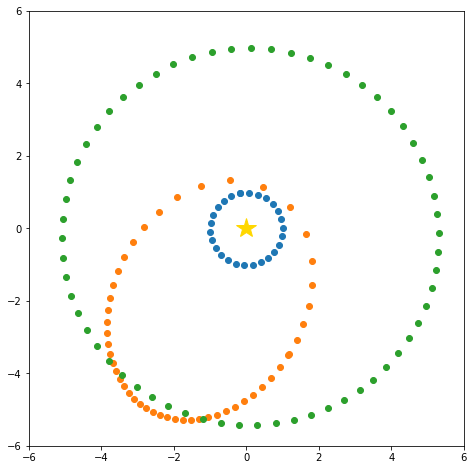

In [8]:
plt.figure(figsize=(12,8))
sps = (1,1)
ax = plt.subplot2grid(sps, (0,0))
ax.set_aspect("equal")
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.plot([0],[0], "*", color="gold", markersize=20)

data_terre = np.loadtxt("earth.txt", skiprows=8)
x_terre, y_terre = data_terre[:,0], data_terre[:,1]
plt.plot(x_terre, y_terre, "o")

data_tchouri = np.loadtxt("tchouri.txt", skiprows=8)
x_tchouri, y_tchouri = data_tchouri[:,0], data_tchouri[:,1]
plt.plot(x_tchouri, y_tchouri, "o")

data_jupiter = np.loadtxt("jupiter.txt", skiprows=8)
x_jupiter, y_jupiter = data_jupiter[:,0], data_jupiter[:,1]
plt.plot(x_jupiter, y_jupiter, "o")